# Course project

This notebook includes the steps to optimize the capacity and dispatch of generators in a stylized energy system. It has been prepared to serve as a tutorial for a simple PyPSA model representing the energy system in one country, city or region. 
 

For the (optional) project of the course [Integrated Energy Grids](https://kurser.dtu.dk/course/2024-2025/46770?menulanguage=en) you need to deliver a report including the sections described at the end of this notebook.

Please, review the [PyPSA tutorial](https://martavp.github.io/integrated-energy-grids/intro-pypsa.html) before starting this project.

:::{note}
If you have not yet set up Python on your computer, you can execute this tutorial in your browser via [Google Colab](https://colab.research.google.com/). Click on the rocket in the top right corner and launch "Colab". If that doesn't work download the `.ipynb` file and import it in [Google Colab](https://colab.research.google.com/).

Then install `pandas` and `pypsa` by executing the following command in a Jupyter cell at the top of the notebook.

```sh
!pip install pandas pypsa
```
:::

In [127]:
!pip install pypsa



[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [23]:
import pandas as pd
import pypsa
import matplotlib.pyplot as plt




We start by creating the network. In this example, the country is modelled as a single node, so the network includes only one bus.

We select the year 2015 and set the hours in that year as snapshots.

We select a country, in this case Denmark (DNK), and add one node (electricity bus) to the network.

In [59]:
network = pypsa.Network()
hours_in_2015 = pd.date_range('2015-01-01 00:00Z',
                              '2015-12-31 23:00Z',
                              freq='h')

network.set_snapshots(hours_in_2015.values)

network.add("Bus",
            "electricity bus")

network.snapshots


DatetimeIndex(['2015-01-01 00:00:00', '2015-01-01 01:00:00',
               '2015-01-01 02:00:00', '2015-01-01 03:00:00',
               '2015-01-01 04:00:00', '2015-01-01 05:00:00',
               '2015-01-01 06:00:00', '2015-01-01 07:00:00',
               '2015-01-01 08:00:00', '2015-01-01 09:00:00',
               ...
               '2015-12-31 14:00:00', '2015-12-31 15:00:00',
               '2015-12-31 16:00:00', '2015-12-31 17:00:00',
               '2015-12-31 18:00:00', '2015-12-31 19:00:00',
               '2015-12-31 20:00:00', '2015-12-31 21:00:00',
               '2015-12-31 22:00:00', '2015-12-31 23:00:00'],
              dtype='datetime64[ns]', name='snapshot', length=8760, freq=None)

The demand is represented by the historical electricity demand in 2015 with hourly resolution.

The file with historical hourly electricity demand for every European country is available in the data folder.

The electricity demand time series were obtained from ENTSOE through the very convenient compilation carried out by the Open Power System Data (OPSD). https://data.open-power-system-data.org/time_series/

In [60]:
# load electricity demand data
df_elec = pd.read_csv('electricity_demand.csv', sep=';', index_col=0) # in MWh
df_elec.index = pd.to_datetime(df_elec.index) #change index to datatime
country='NLD'
print(df_elec[country].head())

utc_time
2015-01-01 00:00:00+00:00    11338.0
2015-01-01 01:00:00+00:00    10917.0
2015-01-01 02:00:00+00:00    10473.0
2015-01-01 03:00:00+00:00    10200.0
2015-01-01 04:00:00+00:00    10182.0
Name: NLD, dtype: float64


In [61]:
# add load to the bus
network.add("Load",
            "load",
            bus="electricity bus",
            p_set=df_elec[country].values)

Index(['load'], dtype='object')

Print the load time series to check that it has been properly added (you should see numbers and not 'NaN')

In [62]:
network.loads_t.p_set

Load,load
snapshot,
2015-01-01 00:00:00,11338.0
2015-01-01 01:00:00,10917.0
2015-01-01 02:00:00,10473.0
2015-01-01 03:00:00,10200.0
2015-01-01 04:00:00,10182.0
...,...
2015-12-31 19:00:00,12958.0
2015-12-31 20:00:00,12263.0
2015-12-31 21:00:00,11772.0


In the optimization, we will minimize the annualized system costs.

We will need to annualize the cost of every generator, we build a function to do it.

In [63]:
def annuity(n,r):
    """ Calculate the annuity factor for an asset with lifetime n years and
    discount rate  r """

    if r > 0:
        return r/(1. - 1./(1.+r)**n)
    else:
        return 1/n


We include solar PV and onshore wind generators.

The capacity factors representing the availability of those generators for every European country can be downloaded from the following repositories (select 'optimal' for PV and onshore for wind).

https://zenodo.org/record/3253876#.XSiVOEdS8l0

https://zenodo.org/record/2613651#.XSiVOkdS8l0

We include also Open Cycle Gas Turbine (OCGT) generators

The cost assumed for the generators are the same as in Table 1 in the paper https://doi.org/10.1016/j.enconman.2019.111977 (open version:  https://arxiv.org/pdf/1906.06936.pdf)

In [64]:
# add the different carriers, only gas emits CO2
network.add("Carrier", "gas", co2_emissions=0.19) # in t_CO2/MWh_th
network.add("Carrier", "onshorewind")
network.add("Carrier", "solar")

# add onshore wind generator
df_onshorewind = pd.read_csv('onshore_wind_1979-2017.csv', sep=';', index_col=0)
df_onshorewind.index = pd.to_datetime(df_onshorewind.index)
CF_wind = df_onshorewind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
#the capacity factor is being extracted with this line above
capital_cost_onshorewind = annuity(30,0.07)*910000*(1+0.033) # in €/MW, this is a formula to calculate annuality in function of years, interest, investment costs and a fix factor
network.add("Generator",
            "onshorewind",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="onshorewind",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_onshorewind,
            marginal_cost = 0,
            p_max_pu = CF_wind.values)

# add solar PV generator
df_solar = pd.read_csv('pv_optimal.csv', sep=';', index_col=0)
df_solar.index = pd.to_datetime(df_solar.index)
CF_solar = df_solar[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
capital_cost_solar = annuity(25,0.07)*425000*(1+0.03) # in €/MW
network.add("Generator",
            "solar",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="solar",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_solar,
            marginal_cost = 0,
            p_max_pu = CF_solar.values)

# add OCGT (Open Cycle Gas Turbine) generator
capital_cost_OCGT = annuity(25,0.07)*560000*(1+0.033) # in €/MW
fuel_cost = 20.1 # in €/MWh_th
efficiency = 0.39 # MWh_elec/MWh_th
marginal_cost_OCGT = fuel_cost/efficiency # in €/MWh_el
network.add("Generator",
            "OCGT",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="gas",
            #p_nom_max=1000,
            capital_cost = capital_cost_OCGT,
            marginal_cost = marginal_cost_OCGT)


Index(['OCGT'], dtype='object')

Print the generator Capacity factor time series to check that it has been properly added (you should see numbers and not 'NaN')

In [65]:
network.generators_t.p_max_pu

Generator,onshorewind,solar
snapshot,,
2015-01-01 00:00:00,0.360,0.0
2015-01-01 01:00:00,0.383,0.0
2015-01-01 02:00:00,0.417,0.0
2015-01-01 03:00:00,0.432,0.0
2015-01-01 04:00:00,0.443,0.0
...,...,...
2015-12-31 19:00:00,0.448,0.0
2015-12-31 20:00:00,0.465,0.0
2015-12-31 21:00:00,0.451,0.0


We find the optimal solution using Gurobi as solver.

In this case, we are optimizing the installed capacity and dispatch of every generator to minimize the total system cost.

In [66]:
network.optimize()

Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 14.00it/s]
INFO:linopy.io: Writing time: 0.94s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 26283 primals, 61323 duals
Objective: 5.98e+09
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


('ok', 'optimal')

The message ('ok' , 'optimal") indicates that the optimizer has found an optimal solution.

The total cost can be read from the network objetive.

In [67]:
print(network.objective/1000000) #in 10^6 €

5979.097417308765


The cost per MWh of electricity produced can also be calculated.

In [68]:
print(network.objective/network.loads_t.p.sum()) # EUR/MWh

Load
load    52.79562
dtype: float64


The optimal capacity for every generator can be shown.

In [69]:
network.generators.p_nom_opt # in MW

Generator
onshorewind    18740.693196
solar          17202.035129
OCGT           17386.333761
Name: p_nom_opt, dtype: float64

We can plot now the dispatch of every generator during the first week of the year and the electricity demand.
We import the matplotlib package which is very useful to plot results.

We can also plot the electricity mix.

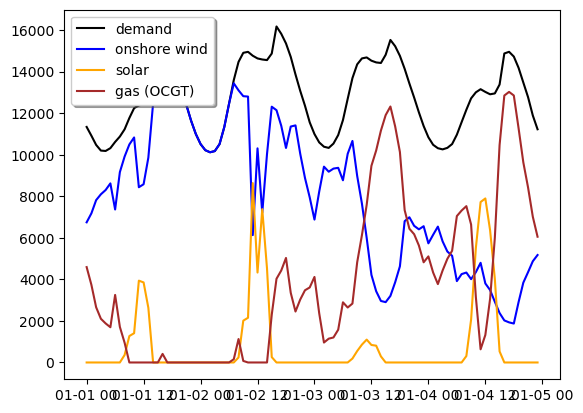

In [70]:
import matplotlib.pyplot as plt

plt.plot(network.loads_t.p['load'][0:96], color='black', label='demand')
plt.plot(network.generators_t.p['onshorewind'][0:96], color='blue', label='onshore wind')
plt.plot(network.generators_t.p['solar'][0:96], color='orange', label='solar')
plt.plot(network.generators_t.p['OCGT'][0:96], color='brown', label='gas (OCGT)')
plt.legend(fancybox=True, shadow=True, loc='best')

In [71]:
def plotEnergyMix():
    labels = ['Onshore Wind',
          'Solar',
          'Gas (OCGT)']
    sizes = [network.generators_t.p['onshorewind'].sum(),
         network.generators_t.p['solar'].sum(),
         network.generators_t.p['OCGT'].sum()]

    colors=['blue', 'orange', 'brown']

    plt.pie(sizes,
        colors=colors,
        labels=labels,
         autopct='%1.1f%%',
        wedgeprops={'linewidth':0})
    plt.axis('equal')

    plt.title('Electricity mix', y=1.07)

Text(0.5, 1.07, 'Electricity mix')

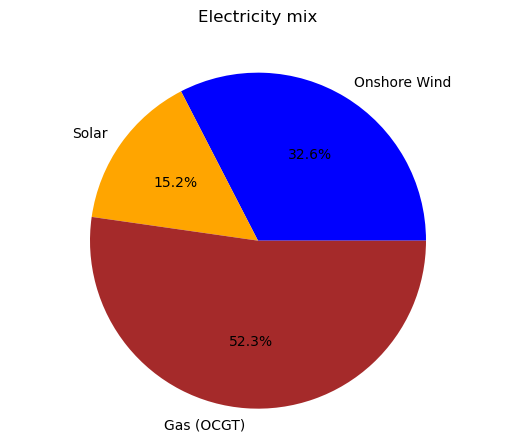

In [72]:
labels = ['Onshore Wind',
          'Solar',
          'Gas (OCGT)']
sizes = [network.generators_t.p['onshorewind'].sum(),
         network.generators_t.p['solar'].sum(),
         network.generators_t.p['OCGT'].sum()]

colors=['blue', 'orange', 'brown']

plt.pie(sizes,
        colors=colors,
        labels=labels,
         autopct='%1.1f%%',
        wedgeprops={'linewidth':0})
plt.axis('equal')

plt.title('Electricity mix', y=1.07)

We can add a global CO2 constraint and solve again.

In [101]:
full_onshore = 18742
full_gas = 17387

In [116]:
CF_wind = df_onshorewind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]

#the capacity factor is being extracted with this line above
capital_cost_onshorewind = annuity(30,0.07)*910000*(1+0.033) # in €/MW, this is a formula to calculate annuality in function of years, interest, investment costs and a fix factor
network.add("Generator",
            "onshorewind",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="onshorewind",
            # p_nom_max=0.99 * full_onshore, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_onshorewind,
            marginal_cost = 0,
            p_max_pu = CF_wind.values,
            overwrite=True)

# add OCGT (Open Cycle Gas Turbine) generator
capital_cost_OCGT = annuity(25,0.07)*560000*(1+0.033) # in €/MW
fuel_cost = 20.1 # in €/MWh_th
efficiency = 0.39 # MWh_elec/MWh_th
marginal_cost_OCGT = fuel_cost/efficiency # in €/MWh_el
network.add("Generator",
            "OCGT",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="gas",
            p_nom_max=0.99*full_gas,
            capital_cost = capital_cost_OCGT,
            marginal_cost = marginal_cost_OCGT,
            overwrite=True)
# add load to the bus
network.add("Load",
            "load",
            bus="electricity bus",
            p_set=df_elec[country].values)
network.optimize()

Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 14.67it/s]
INFO:linopy.io: Writing time: 1.01s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 26283 primals, 61324 duals
Objective: 6.41e+09
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


('ok', 'optimal')

In [117]:
#highest limit
network.generators.p_nom_opt #in MW

Generator
solar           8747.620934
onshorewind    37985.555556
OCGT           17213.130000
Name: p_nom_opt, dtype: float64

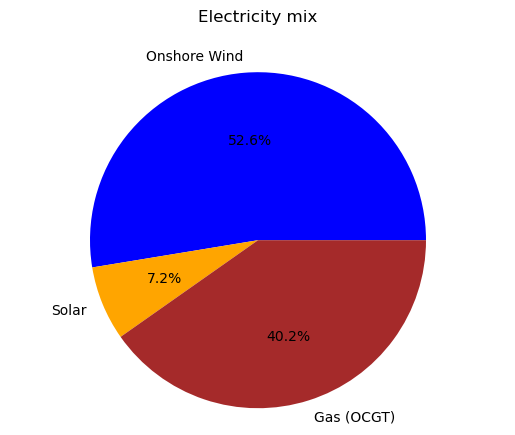

In [118]:
plotEnergyMix()

In [119]:
CF_wind = df_onshorewind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]

#the capacity factor is being extracted with this line above
capital_cost_onshorewind = annuity(30,0.07)*910000*(1+0.033) # in €/MW, this is a formula to calculate annuality in function of years, interest, investment costs and a fix factor
network.add("Generator",
            "onshorewind",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="onshorewind",
            # p_nom_max=0.99 * full_onshore, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_onshorewind,
            marginal_cost = 0,
            p_max_pu = CF_wind.values,
            overwrite=True)

# add OCGT (Open Cycle Gas Turbine) generator
capital_cost_OCGT = annuity(25,0.07)*560000*(1+0.033) # in €/MW
fuel_cost = 20.1 # in €/MWh_th
efficiency = 0.39 # MWh_elec/MWh_th
marginal_cost_OCGT = fuel_cost/efficiency # in €/MWh_el
network.add("Generator",
            "OCGT",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="gas",
            p_nom_max=0.98*full_gas,
            capital_cost = capital_cost_OCGT,
            marginal_cost = marginal_cost_OCGT,
            overwrite=True)
# add load to the bus
network.add("Load",
            "load",
            bus="electricity bus",
            p_set=df_elec[country].values)
network.optimize()

Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 14.99it/s]
INFO:linopy.io: Writing time: 0.97s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 26283 primals, 61324 duals
Objective: 7.23e+09
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


('ok', 'optimal')

Generator
solar             -0.000000
onshorewind    57304.444444
OCGT           17039.260000
Name: p_nom_opt, dtype: float64

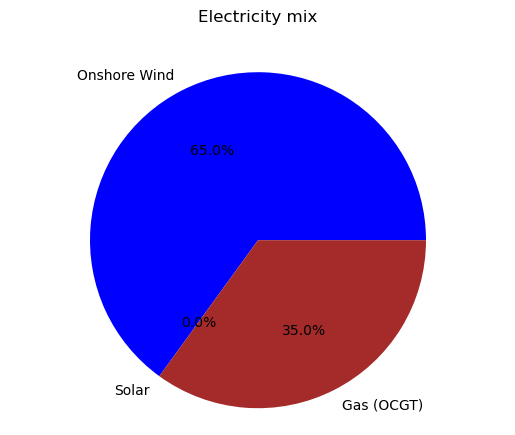

In [120]:
plotEnergyMix()
network.generators.p_nom_opt #in MW

In [121]:
CF_wind = df_onshorewind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]

#the capacity factor is being extracted with this line above
capital_cost_onshorewind = annuity(30,0.07)*910000*(1+0.033) # in €/MW, this is a formula to calculate annuality in function of years, interest, investment costs and a fix factor
network.add("Generator",
            "onshorewind",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="onshorewind",
            # p_nom_max=0.99 * full_onshore, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_onshorewind,
            marginal_cost = 0,
            p_max_pu = CF_wind.values,
            overwrite=True)

# add OCGT (Open Cycle Gas Turbine) generator
capital_cost_OCGT = annuity(25,0.07)*560000*(1+0.033) # in €/MW
fuel_cost = 20.1 # in €/MWh_th
efficiency = 0.39 # MWh_elec/MWh_th
marginal_cost_OCGT = fuel_cost/efficiency # in €/MWh_el
network.add("Generator",
            "OCGT",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="gas",
            p_nom_max=0.95*full_gas,
            capital_cost = capital_cost_OCGT,
            marginal_cost = marginal_cost_OCGT,
            overwrite=True)
# add load to the bus
network.add("Load",
            "load",
            bus="electricity bus",
            p_set=df_elec[country].values)
network.optimize()

Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 14.01it/s]
INFO:linopy.io: Writing time: 1.03s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 26283 primals, 61324 duals
Objective: 1.06e+10
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


('ok', 'optimal')

Generator
solar              -0.000000
onshorewind    115261.111111
OCGT            16517.650000
Name: p_nom_opt, dtype: float64

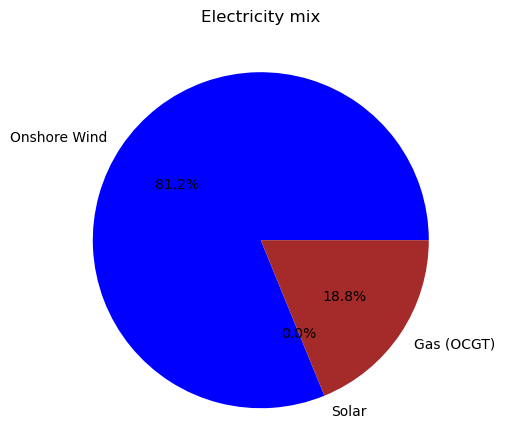

In [122]:
plotEnergyMix()
network.generators.p_nom_opt #in MW

In [123]:
network.loads_t.p_set

Load,load
snapshot,
2015-01-01 00:00:00,11338.0
2015-01-01 01:00:00,10917.0
2015-01-01 02:00:00,10473.0
2015-01-01 03:00:00,10200.0
2015-01-01 04:00:00,10182.0
...,...
2015-12-31 19:00:00,12958.0
2015-12-31 20:00:00,12263.0
2015-12-31 21:00:00,11772.0


In [82]:
CF_wind = df_onshorewind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]

#the capacity factor is being extracted with this line above
capital_cost_onshorewind = annuity(30,0.07)*910000*(1+0.033) # in €/MW, this is a formula to calculate annuality in function of years, interest, investment costs and a fix factor
network.add("Generator",
            "onshorewind",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="onshorewind",
            # p_nom_max=0.99 * full_onshore, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_onshorewind,
            marginal_cost = 0,
            p_max_pu = CF_wind.values,
            overwrite=True)

# add OCGT (Open Cycle Gas Turbine) generator
capital_cost_OCGT = annuity(25,0.07)*560000*(1+0.033) # in €/MW
fuel_cost = 20.1 # in €/MWh_th
efficiency = 0.39 # MWh_elec/MWh_th
marginal_cost_OCGT = fuel_cost/efficiency # in €/MWh_el
network.add("Generator",
            "OCGT",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="gas",
            p_nom_max=0.9*full_gas,
            capital_cost = capital_cost_OCGT,
            marginal_cost = marginal_cost_OCGT,
            overwrite=True)
# add load to the bus
network.add("Load",
            "load",
            bus="electricity bus",
            p_set=df_elec[country].values)
network.optimize()

Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 14.21it/s]
INFO:linopy.io: Writing time: 0.91s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 26283 primals, 61324 duals
Objective: 1.74e+10
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


('ok', 'optimal')

Generator
solar             893.518519
onshorewind    211855.555556
OCGT            15648.300000
Name: p_nom_opt, dtype: float64

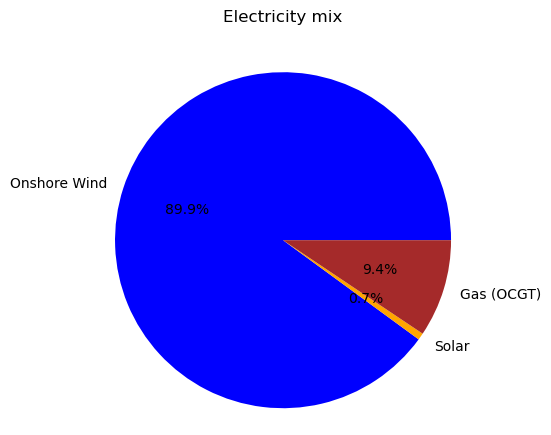

In [83]:
plotEnergyMix()
network.generators.p_nom_opt #in MW

In [84]:
CF_wind = df_onshorewind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]

#the capacity factor is being extracted with this line above
capital_cost_onshorewind = annuity(30,0.07)*910000*(1+0.033) # in €/MW, this is a formula to calculate annuality in function of years, interest, investment costs and a fix factor
network.add("Generator",
            "onshorewind",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="onshorewind",
            # p_nom_max=0.99 * full_onshore, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_onshorewind,
            marginal_cost = 0,
            p_max_pu = CF_wind.values,
            overwrite=True)

# add OCGT (Open Cycle Gas Turbine) generator
capital_cost_OCGT = annuity(25,0.07)*560000*(1+0.033) # in €/MW
fuel_cost = 20.1 # in €/MWh_th
efficiency = 0.39 # MWh_elec/MWh_th
marginal_cost_OCGT = fuel_cost/efficiency # in €/MWh_el
network.add("Generator",
            "OCGT",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="gas",
            p_nom_max=0.8*full_gas,
            capital_cost = capital_cost_OCGT,
            marginal_cost = marginal_cost_OCGT,
            overwrite=True)
network.optimize()

Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 15.09it/s]
INFO:linopy.io: Writing time: 1.0s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 26283 primals, 61324 duals
Objective: 3.17e+10
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


('ok', 'optimal')

Generator
solar            3224.299910
onshorewind    405044.444444
OCGT            13909.600000
Name: p_nom_opt, dtype: float64

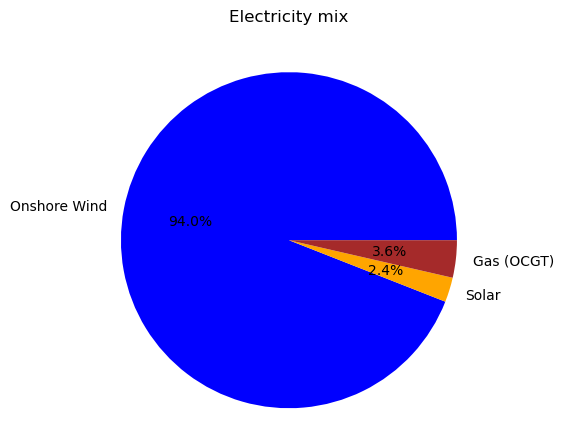

In [85]:
plotEnergyMix()
network.generators.p_nom_opt #in MW

In [86]:
CF_wind = df_onshorewind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]

#the capacity factor is being extracted with this line above
capital_cost_onshorewind = annuity(30,0.07)*910000*(1+0.033) # in €/MW, this is a formula to calculate annuality in function of years, interest, investment costs and a fix factor
network.add("Generator",
            "onshorewind",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="onshorewind",
            p_nom_max=0.99 * full_onshore, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_onshorewind,
            marginal_cost = 0,
            p_max_pu = CF_wind.values,
            overwrite=True)

# add OCGT (Open Cycle Gas Turbine) generator
capital_cost_OCGT = annuity(25,0.07)*560000*(1+0.033) # in €/MW
fuel_cost = 20.1 # in €/MWh_th
efficiency = 0.39 # MWh_elec/MWh_th
marginal_cost_OCGT = fuel_cost/efficiency # in €/MWh_el
network.add("Generator",
            "OCGT",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="gas",
            # p_nom_max=0.99*full_gas,
            capital_cost = capital_cost_OCGT,
            marginal_cost = marginal_cost_OCGT,
            overwrite=True)
network.optimize()

Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 13.47it/s]
INFO:linopy.io: Writing time: 0.96s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 26283 primals, 61324 duals
Objective: 5.98e+09
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


('ok', 'optimal')

Generator
solar          17341.609945
onshorewind    18554.580000
OCGT           17388.008780
Name: p_nom_opt, dtype: float64

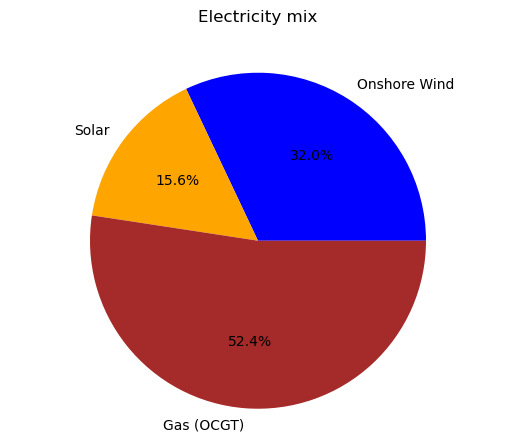

In [87]:
plotEnergyMix()
network.generators.p_nom_opt #in MW

In [114]:
CF_wind = df_onshorewind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]

#the capacity factor is being extracted with this line above
capital_cost_onshorewind = annuity(30,0.07)*910000*(1+0.033) # in €/MW, this is a formula to calculate annuality in function of years, interest, investment costs and a fix factor
network.add("Generator",
            "onshorewind",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="onshorewind",
            p_nom_max=0.98 * full_onshore, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_onshorewind,
            marginal_cost = 0,
            p_max_pu = CF_wind.values,
            overwrite=True)

# add OCGT (Open Cycle Gas Turbine) generator
capital_cost_OCGT = annuity(25,0.07)*560000*(1+0.033) # in €/MW
fuel_cost = 20.1 # in €/MWh_th
efficiency = 0.39 # MWh_elec/MWh_th
marginal_cost_OCGT = fuel_cost/efficiency # in €/MWh_el
network.add("Generator",
            "OCGT",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="gas",
            # p_nom_max=0.99*full_gas,
            capital_cost = capital_cost_OCGT,
            marginal_cost = marginal_cost_OCGT,
            overwrite=True)
network.optimize()

Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 13.48it/s]
INFO:linopy.io: Writing time: 0.93s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 26283 primals, 61324 duals
Objective: 5.98e+09
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


('ok', 'optimal')

In [115]:
network.loads_t.p_set

Load,load
snapshot,
2015-01-01 00:00:00,11338.0
2015-01-01 01:00:00,10917.0
2015-01-01 02:00:00,10473.0
2015-01-01 03:00:00,10200.0
2015-01-01 04:00:00,10182.0
...,...
2015-12-31 19:00:00,12958.0
2015-12-31 20:00:00,12263.0
2015-12-31 21:00:00,11772.0


Generator
solar          17397.582457
onshorewind    18367.160000
OCGT           17389.695560
Name: p_nom_opt, dtype: float64

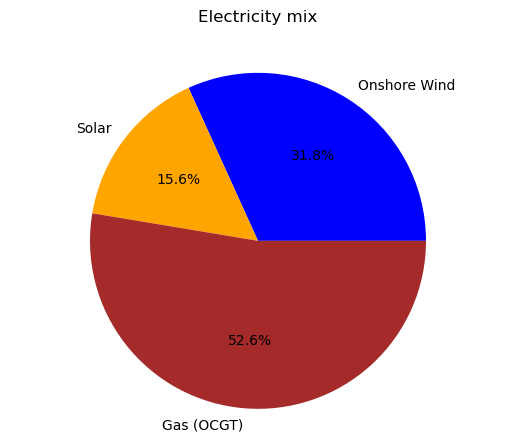

In [89]:
plotEnergyMix()
network.generators.p_nom_opt #in MW

In [90]:
CF_wind = df_onshorewind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]

#the capacity factor is being extracted with this line above
capital_cost_onshorewind = annuity(30,0.07)*910000*(1+0.033) # in €/MW, this is a formula to calculate annuality in function of years, interest, investment costs and a fix factor
network.add("Generator",
            "onshorewind",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="onshorewind",
            p_nom_max=0.95 * full_onshore, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_onshorewind,
            marginal_cost = 0,
            p_max_pu = CF_wind.values,
            overwrite=True)

# add OCGT (Open Cycle Gas Turbine) generator
capital_cost_OCGT = annuity(25,0.07)*560000*(1+0.033) # in €/MW
fuel_cost = 20.1 # in €/MWh_th
efficiency = 0.39 # MWh_elec/MWh_th
marginal_cost_OCGT = fuel_cost/efficiency # in €/MWh_el
network.add("Generator",
            "OCGT",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="gas",
            # p_nom_max=0.99*full_gas,
            capital_cost = capital_cost_OCGT,
            marginal_cost = marginal_cost_OCGT,
            overwrite=True)
network.optimize()

Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 13.86it/s]
INFO:linopy.io: Writing time: 0.96s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 26283 primals, 61324 duals
Objective: 5.98e+09
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


('ok', 'optimal')

Generator
solar          17662.726244
onshorewind    17804.900000
OCGT           17394.755900
Name: p_nom_opt, dtype: float64

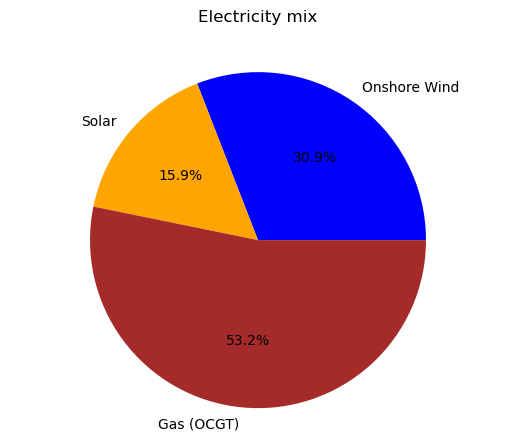

In [91]:
plotEnergyMix()
network.generators.p_nom_opt #in MW

In [92]:
CF_wind = df_onshorewind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]

#the capacity factor is being extracted with this line above
capital_cost_onshorewind = annuity(30,0.07)*910000*(1+0.033) # in €/MW, this is a formula to calculate annuality in function of years, interest, investment costs and a fix factor
network.add("Generator",
            "onshorewind",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="onshorewind",
            p_nom_max=0.90 * full_onshore, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_onshorewind,
            marginal_cost = 0,
            p_max_pu = CF_wind.values,
            overwrite=True)

# add OCGT (Open Cycle Gas Turbine) generator
capital_cost_OCGT = annuity(25,0.07)*560000*(1+0.033) # in €/MW
fuel_cost = 20.1 # in €/MWh_th
efficiency = 0.39 # MWh_elec/MWh_th
marginal_cost_OCGT = fuel_cost/efficiency # in €/MWh_el
network.add("Generator",
            "OCGT",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="gas",
            # p_nom_max=0.99*full_gas,
            capital_cost = capital_cost_OCGT,
            marginal_cost = marginal_cost_OCGT,
            overwrite=True)
network.optimize()

Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 13.11it/s]
INFO:linopy.io: Writing time: 0.97s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 26283 primals, 61324 duals
Objective: 5.99e+09
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


('ok', 'optimal')

Generator
solar          18105.663427
onshorewind    16867.800000
OCGT           17403.189800
Name: p_nom_opt, dtype: float64

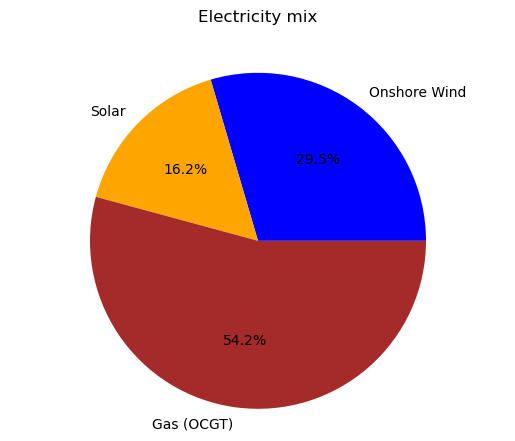

In [93]:
plotEnergyMix()
network.generators.p_nom_opt #in MW

In [94]:
CF_wind = df_onshorewind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]

#the capacity factor is being extracted with this line above
capital_cost_onshorewind = annuity(30,0.07)*910000*(1+0.033) # in €/MW, this is a formula to calculate annuality in function of years, interest, investment costs and a fix factor
network.add("Generator",
            "onshorewind",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="onshorewind",
            p_nom_max=0.80 * full_onshore, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_onshorewind,
            marginal_cost = 0,
            p_max_pu = CF_wind.values,
            overwrite=True)

# add OCGT (Open Cycle Gas Turbine) generator
capital_cost_OCGT = annuity(25,0.07)*560000*(1+0.033) # in €/MW
fuel_cost = 20.1 # in €/MWh_th
efficiency = 0.39 # MWh_elec/MWh_th
marginal_cost_OCGT = fuel_cost/efficiency # in €/MWh_el
network.add("Generator",
            "OCGT",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="gas",
            # p_nom_max=0.99*full_gas,
            capital_cost = capital_cost_OCGT,
            marginal_cost = marginal_cost_OCGT,
            overwrite=True)
network.optimize()

Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 13.25it/s]
INFO:linopy.io: Writing time: 0.9s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 26283 primals, 61324 duals
Objective: 6.01e+09
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


('ok', 'optimal')

Generator
solar          18835.905441
onshorewind    14993.600000
OCGT           17420.057600
Name: p_nom_opt, dtype: float64

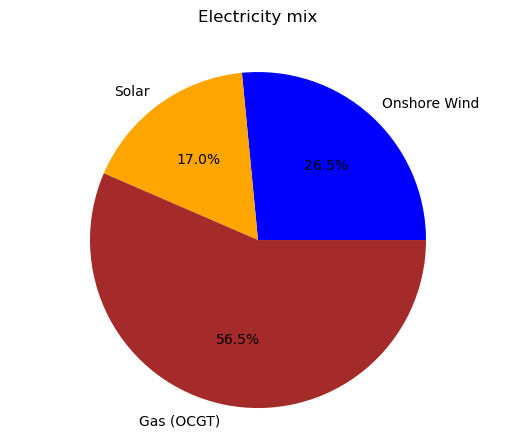

In [95]:
plotEnergyMix()
network.generators.p_nom_opt #in MW

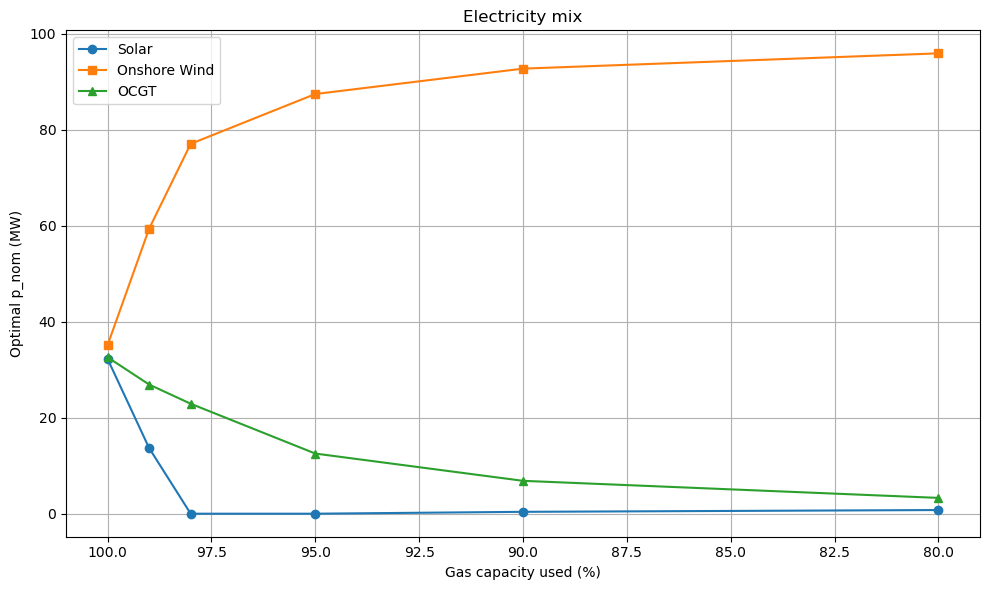

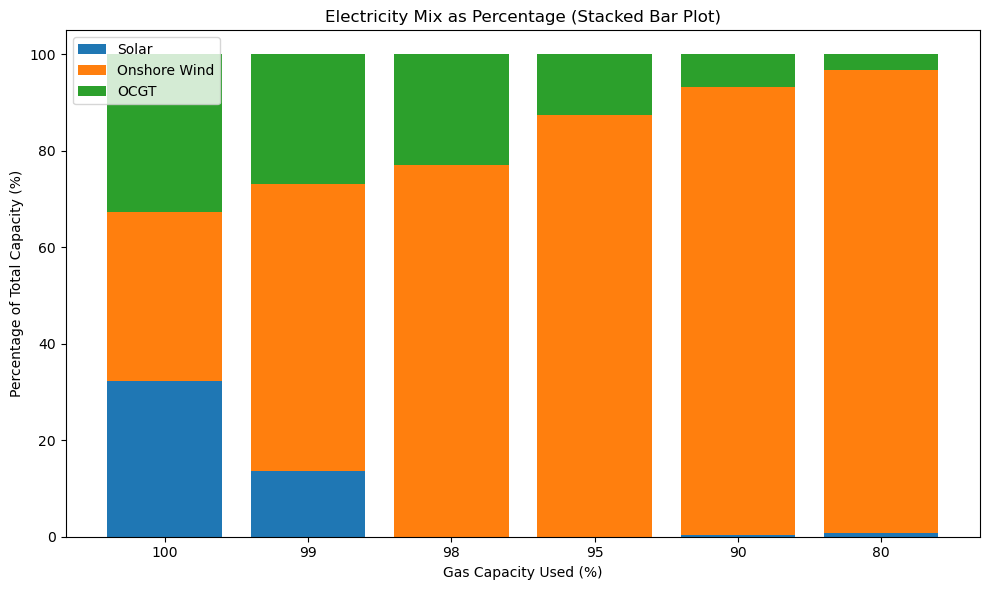

In [126]:
import matplotlib.pyplot as plt
import numpy as np

# Gas capacity percentages
gas_capacity = [100, 99, 98, 95, 90,80]

# Optimal p_nom values in MW for each generator
solar = [17202, 8748, 0, 0, 894,3224]
onshorewind = [18741, 37986, 57304, 115261, 211856, 405044]
ocgt = [17386, 17213, 17039, 16517, 15648,13909]

# Convert to numpy arrays for easier manipulation
solar = np.array(solar)
onshorewind = np.array(onshorewind)
ocgt = np.array(ocgt)

# Total p_nom at each gas capacity
total = solar + onshorewind + ocgt

# Compute percentages
solar_pct = 100 * solar / total
onshorewind_pct = 100 * onshorewind / total
ocgt_pct = 100 * ocgt / total

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(gas_capacity, solar_pct, marker='o', label='Solar')
plt.plot(gas_capacity, onshorewind_pct, marker='s', label='Onshore Wind')
plt.plot(gas_capacity, ocgt_pct, marker='^', label='OCGT')

# Axis labels and title
plt.xlabel('Gas capacity used (%)')
plt.ylabel('Optimal p_nom (MW)')
plt.title('Electricity mix')
plt.legend()
plt.grid(True)
plt.gca().invert_xaxis()  # Optional: if you want 100% on the left and 90% on the right
plt.tight_layout()
plt.show()

bar_width = 0.8
x = np.arange(len(gas_capacity))

plt.figure(figsize=(10, 6))
plt.bar(x, solar_pct, label='Solar')
plt.bar(x, onshorewind_pct, bottom=solar_pct, label='Onshore Wind')
plt.bar(x, ocgt_pct, bottom=solar_pct + onshorewind_pct, label='OCGT')

plt.xticks(x, gas_capacity)
plt.xlabel('Gas Capacity Used (%)')
plt.ylabel('Percentage of Total Capacity (%)')
plt.title('Electricity Mix as Percentage (Stacked Bar Plot)')
plt.legend()
plt.tight_layout()
plt.show()


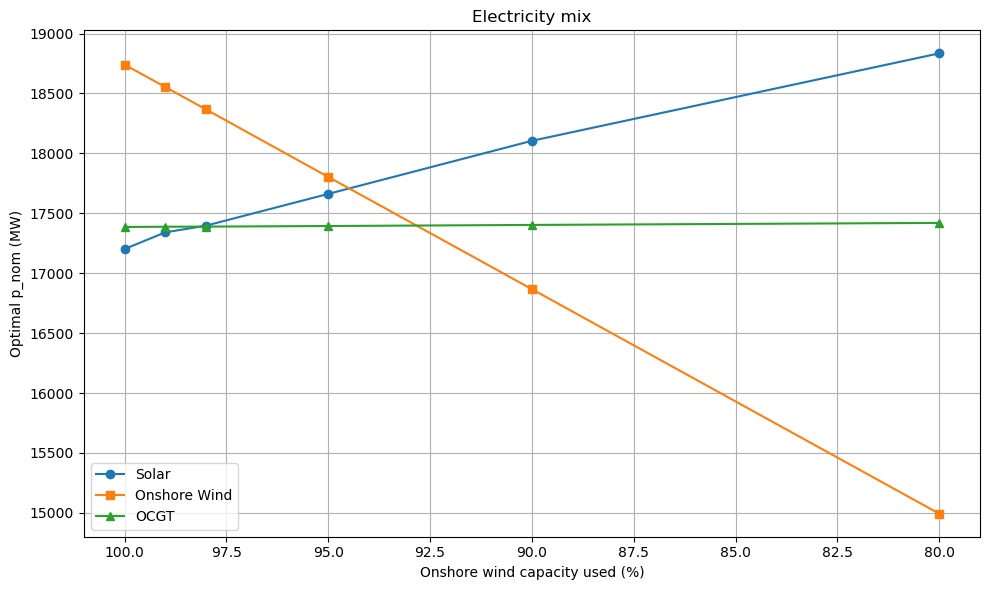

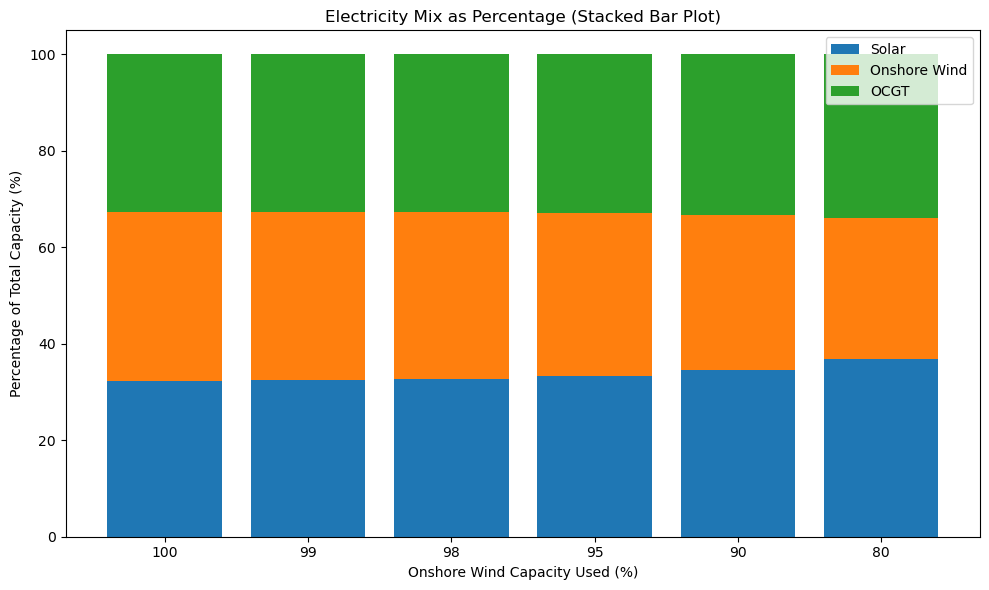

In [128]:
import matplotlib.pyplot as plt
import numpy as np

# Gas capacity percentages
wind_capacity = [100, 99, 98, 95, 90,80]

# Optimal p_nom values in MW for each generator
solar = [17202,17341,17397,17662,18105,18835]
onshorewind = [18741, 18554,18367,17804,16867,14993]
ocgt = [17386,17388,17389,17394,17403,17420 ]

# Convert to numpy arrays for easier manipulation
solar = np.array(solar)
onshorewind = np.array(onshorewind)
ocgt = np.array(ocgt)

# Total p_nom at each gas capacity
total = solar + onshorewind + ocgt

# Compute percentages
solar_pct = 100 * solar / total
onshorewind_pct = 100 * onshorewind / total
ocgt_pct = 100 * ocgt / total

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(wind_capacity, solar, marker='o', label='Solar')
plt.plot(wind_capacity, onshorewind, marker='s', label='Onshore Wind')
plt.plot(wind_capacity, ocgt, marker='^', label='OCGT')

# Axis labels and title
plt.xlabel('Onshore wind capacity used (%)')
plt.ylabel('Optimal p_nom (MW)')
plt.title('Electricity mix')
plt.legend()
plt.grid(True)
plt.gca().invert_xaxis()  # Optional: if you want 100% on the left and 90% on the right
plt.tight_layout()
plt.show()

bar_width = 0.8
x = np.arange(len(gas_capacity))

plt.figure(figsize=(10, 6))
plt.bar(x, solar_pct, label='Solar')
plt.bar(x, onshorewind_pct, bottom=solar_pct, label='Onshore Wind')
plt.bar(x, ocgt_pct, bottom=solar_pct + onshorewind_pct, label='OCGT')

plt.xticks(x, gas_capacity)
plt.xlabel('Onshore Wind Capacity Used (%)')
plt.ylabel('Percentage of Total Capacity (%)')
plt.title('Electricity Mix as Percentage (Stacked Bar Plot)')
plt.legend()
plt.tight_layout()
plt.show()

